### Cab-Driver Agent

In [2]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [4]:
# Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size
        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.001
        self.epsilon = 1
        self.epsilon_max = 1.0
        self.epsilon_decay = -0.0005
        self.epsilon_min = 0.00001
        # batch size
        self.batch_size = 32
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()



    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets  
        model.add(Dense(32, input_dim=self.state_size, activation='relu'))
        model.add(Dense(32, kernel_initializer='normal', activation='relu'))
        # Output layer
        model.add(Dense(self.action_size, kernel_initializer='normal', activation='relu'))
        # Compile the model
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, possible_actions, actions):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment       
        z = np.random.rand()
        if(z <= self.epsilon):
            # Choose a random action - explore
            choice = random.choice(possible_actions)
        else:
            # Choose the action with highest q-value - q(s,a)
            state = np.array(env.state_encod_arch1(state)).reshape(1,36)
            # Predict q-value
            q_value = self.model.predict(state)
            possible_q_val = [q_value[0][action] for action in possible_actions]
            choice = possible_actions[np.argmax(possible_q_val)]
        return choice
        
        

    def append_sample(self, state, action, reward, next_state, done):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, done))
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # Initialize metrices
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []
            
            # Get update_input, update_output, action, reward, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_flag = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_flag)
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
            
            # 2. Get the target for the Q-network
            target_qval = self.target_model.predict(update_output)

            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                if(done[i]):
                    target[i][actions[i]] = rewards[i]
                else:
                    target[i][actions[i]] = rewards[i] + self.discount_factor*np.max(target_qval[i])
                
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)


            
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        # Track state [0,0,0] and action (0,2)
        track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)
        q_value = self.model.predict(track_state)
        self.states_tracked.append(q_value[0][2])
  
        
    def save(self, name):
        self.model.save(name)
    
    
    def get_model_weights(self):
        return self.model.get_weights()



### DQN block

In [6]:
Episodes = 5000
episode_time = 24*30
m = 5
t = 24
d = 7

# Instantiate Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# state and action size
state_size = m+t+d
action_size = len(action_space)

agent = DQNAgent(state_size=state_size, action_size=action_size)

rewards_episode, episodes = [],[]
rewards_init = []

C:\Users\HP\anaconda3\lib\site-packages\tensorflow-2.5.0-py3.8-win-amd64.egg\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [7]:
start_time = time.time()
# score_tracked = []

for episode in range(Episodes):

    # Write code here
    terminal_state = False
    score = 0
    total_time = 0
    
    # Call the environment
    # Call all the initialised variables of the environment
    env = CabDriver()
    action_space, state_space, state = env.reset()
    init_state = env.state_init

    #Call the DQN agent
    
    while not terminal_state:
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        possible_actions_index, actions = env.requests(state)
        action = agent.get_action(state, possible_actions_index, actions)
        # 2. Evaluate your reward and next state
        next_state, reward, step_time = env.step(state, env.action_space[action], Time_matrix)
        next_state = [int(x) for x in next_state]
        total_time += step_time
        if(total_time > episode_time):
            terminal_state = True
        else:
            # 3. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, terminal_state)
            # 4. Train the model by calling function agent.train_model
            agent.train_model()
            # 5. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state
            
    # Total rewards per episode
    rewards_episode.append(score)
    episodes.append(episode)
    
    # epsilon-decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)
    
    # every 20-episodes
    if((episode+1)%20==0):
        print('-'*20, 'episode {0}'.format(episode+1), '-'*20)
        print("reward {0}, epsilon {1}, total_time {2}".format(score, agent.epsilon, total_time))
    
    
    # Save the Q-values of the state, action pair for tracking
    if((episode+1)%5 == 0):
        agent.save_tracking_states()

    
    if(episode%500 == 0):
        print("Saving Model {}".format(episode))
        save_obj(agent.get_model_weights(), "model/model_weights")


elapsed_time = time.time() - start_time
print(elapsed_time)
        

Saving Model 0
-------------------- episode 20 --------------------
reward -195.0, epsilon 0.9905350769930761, total_time 728
-------------------- episode 40 --------------------
reward 72.0, epsilon 0.9806790882997144, total_time 730
-------------------- episode 60 --------------------
reward -134.0, epsilon 0.9709211683324178, total_time 724
-------------------- episode 80 --------------------
reward -49.0, epsilon 0.9612603412910584, total_time 725
-------------------- episode 100 --------------------
reward -227.0, epsilon 0.9516956410848808, total_time 721
-------------------- episode 120 --------------------
reward -232.0, epsilon 0.9422261112358942, total_time 730
-------------------- episode 140 --------------------
reward -223.0, epsilon 0.9328508047832221, total_time 728
-------------------- episode 160 --------------------
reward -135.0, epsilon 0.9235687841884068, total_time 730
-------------------- episode 180 --------------------
reward -75.0, epsilon 0.9143791212416534, 

-------------------- episode 1500 --------------------
reward 730.0, epsilon 0.47259806904509577, total_time 729
Saving Model 1500
-------------------- episode 1520 --------------------
reward 788.0, epsilon 0.4678956396882749, total_time 729
-------------------- episode 1540 --------------------
reward 445.0, epsilon 0.46324000028533724, total_time 721
-------------------- episode 1560 --------------------
reward 640.0, epsilon 0.4586306852684627, total_time 732
-------------------- episode 1580 --------------------
reward 806.0, epsilon 0.4540672337023085, total_time 732
-------------------- episode 1600 --------------------
reward 932.0, epsilon 0.4495491892379152, total_time 729
-------------------- episode 1620 --------------------
reward 607.0, epsilon 0.4450761000670712, total_time 725
-------------------- episode 1640 --------------------
reward 945.0, epsilon 0.44064751887713194, total_time 721
-------------------- episode 1660 --------------------
reward 972.0, epsilon 0.4362

-------------------- episode 2960 --------------------
reward 1230.0, epsilon 0.22774925817210187, total_time 725
-------------------- episode 2980 --------------------
reward 1078.0, epsilon 0.2254831151897858, total_time 722
-------------------- episode 3000 --------------------
reward 950.0, epsilon 0.22323952070689196, total_time 729
Saving Model 3000
-------------------- episode 3020 --------------------
reward 1409.0, epsilon 0.22101825036210232, total_time 721
-------------------- episode 3040 --------------------
reward 1243.0, epsilon 0.21881908202653141, total_time 721
-------------------- episode 3060 --------------------
reward 1188.0, epsilon 0.216641795781513, total_time 728
-------------------- episode 3080 --------------------
reward 1189.0, epsilon 0.21448617389660815, total_time 727
-------------------- episode 3100 --------------------
reward 765.0, epsilon 0.21235200080783204, total_time 726
-------------------- episode 3120 --------------------
reward 1006.0, epsil

-------------------- episode 4400 --------------------
reward 1242.0, epsilon 0.11085746520848058, total_time 726
-------------------- episode 4420 --------------------
reward 1233.0, epsilon 0.10975441499951036, total_time 723
-------------------- episode 4440 --------------------
reward 1332.0, epsilon 0.10866234032350246, total_time 727
-------------------- episode 4460 --------------------
reward 1141.0, epsilon 0.10758113197207911, total_time 721
-------------------- episode 4480 --------------------
reward 1446.0, epsilon 0.10651068182350425, total_time 728
-------------------- episode 4500 --------------------
reward 1532.0, epsilon 0.10545088283187094, total_time 727
Saving Model 4500
-------------------- episode 4520 --------------------
reward 1028.0, epsilon 0.1044016290163968, total_time 726
-------------------- episode 4540 --------------------
reward 1185.0, epsilon 0.103362815450826, total_time 725
-------------------- episode 4560 --------------------
reward 1508.0, eps

### Tracking Convergence

In [8]:
# Let's check Q-values which we have tracked for state [0,0,0] and action (0,2)

agent.states_tracked

[4.1681123,
 12.747192,
 16.059315,
 17.487007,
 20.855309,
 20.804623,
 21.416431,
 23.665525,
 23.328196,
 26.1875,
 21.667364,
 21.529305,
 19.233217,
 21.020754,
 21.377281,
 24.824112,
 26.409883,
 23.658348,
 25.709969,
 24.68763,
 21.421398,
 19.887007,
 17.739756,
 12.763306,
 15.764963,
 21.507063,
 22.980661,
 25.793144,
 23.97913,
 20.565847,
 17.089367,
 17.718647,
 20.31318,
 26.666403,
 22.5295,
 19.571863,
 13.408141,
 13.627935,
 13.637752,
 14.010419,
 14.334538,
 13.943308,
 16.152681,
 17.201168,
 14.125783,
 14.317131,
 14.866492,
 17.040659,
 20.374035,
 18.724297,
 15.50294,
 11.5319195,
 9.830789,
 10.850944,
 10.678507,
 10.408395,
 6.8647733,
 7.8039784,
 5.5792904,
 6.408905,
 7.7534437,
 7.044087,
 9.313672,
 10.369141,
 10.483643,
 10.038935,
 11.705817,
 13.213609,
 12.7374935,
 11.060551,
 9.646422,
 9.255022,
 8.359957,
 7.129784,
 7.740602,
 8.751254,
 9.895755,
 9.4691,
 8.76053,
 10.101862,
 11.465488,
 12.879854,
 11.259686,
 14.2213,
 13.509602,
 14.

In [9]:
# Let's check for the rewards generated in each episode

rewards_episode

[-314.0,
 -278.0,
 -252.0,
 -150.0,
 -178.0,
 -210.0,
 -156.0,
 -228.0,
 -297.0,
 -136.0,
 -206.0,
 -249.0,
 -90.0,
 60.0,
 -108.0,
 -205.0,
 -223.0,
 -139.0,
 -137.0,
 -195.0,
 -125.0,
 -330.0,
 -310.0,
 -129.0,
 345.0,
 -208.0,
 -106.0,
 -112.0,
 -318.0,
 -256.0,
 -126.0,
 -63.0,
 -21.0,
 -307.0,
 -234.0,
 -327.0,
 -452.0,
 -303.0,
 21.0,
 72.0,
 -157.0,
 83.0,
 157.0,
 -181.0,
 -30.0,
 -202.0,
 -256.0,
 -83.0,
 -202.0,
 -342.0,
 -387.0,
 33.0,
 -224.0,
 -171.0,
 -80.0,
 163.0,
 97.0,
 -111.0,
 -143.0,
 -134.0,
 108.0,
 -235.0,
 92.0,
 -180.0,
 -161.0,
 -209.0,
 -24.0,
 -187.0,
 -189.0,
 -238.0,
 -36.0,
 -303.0,
 -184.0,
 -186.0,
 -9.0,
 108.0,
 16.0,
 -206.0,
 -343.0,
 -49.0,
 -55.0,
 225.0,
 -247.0,
 -153.0,
 -279.0,
 -105.0,
 -390.0,
 3.0,
 -30.0,
 -102.0,
 -523.0,
 -112.0,
 141.0,
 16.0,
 -166.0,
 -198.0,
 -98.0,
 -432.0,
 -178.0,
 -227.0,
 -160.0,
 -217.0,
 -189.0,
 -231.0,
 -174.0,
 -84.0,
 -297.0,
 -206.0,
 75.0,
 -90.0,
 -161.0,
 -135.0,
 -251.0,
 -495.0,
 6.0,
 9.0,
 -184.0,

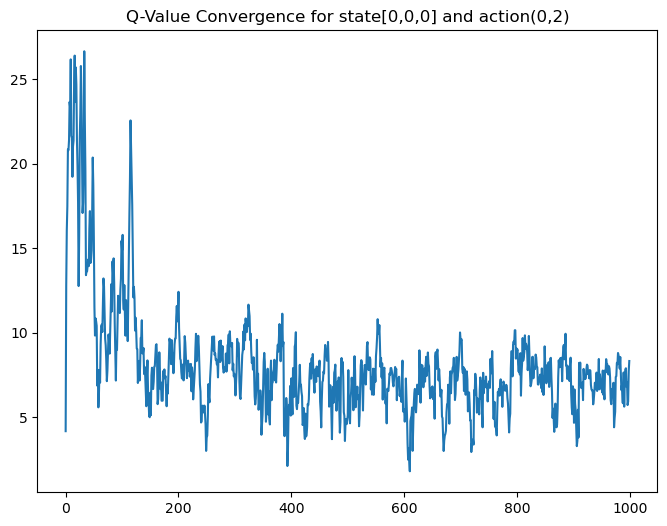

In [14]:
# Q-Value convergence plot

plt.figure(0, figsize=(8,6))
plt.plot(range(0, len(agent.states_tracked)), agent.states_tracked)
plt.title('Q-Value Convergence for state[0,0,0] and action(0,2)')
plt.show()

**Observation:** Q-values for sample state action pair ([0,0,0], (0,2)) is getting converged after around 400( 2000 episodes)

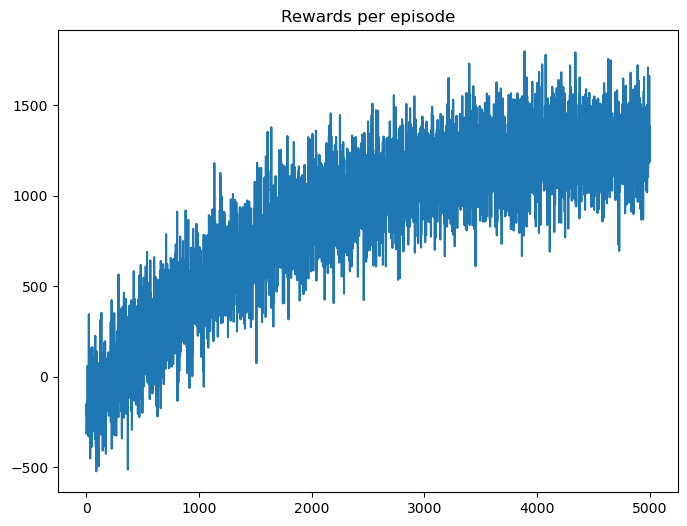

In [11]:
# Rewards per Episode plot

plt.figure(0, figsize=(8,6))
plt.plot(episodes, rewards_episode)
plt.title('Rewards per episode')
plt.show()

**Observations**: 
1. Reward increases as number of episode increases and it does not change much after almost 4000 episodes.
2. We can conclude that reward converges after 4000 episodes.

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [12]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

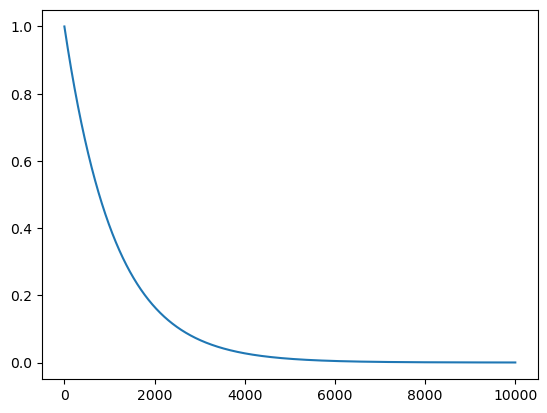

In [13]:
plt.plot(time, epsilon)
plt.show()